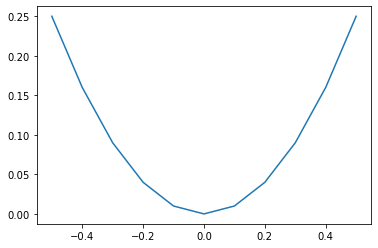

In [1]:
from matplotlib import pyplot
import numpy as np

def calculate(x):
    return x*x

inputs = [i/10 for i in np.arange(-5, 6, 1)]

outputs = [calculate(x) for x in inputs]

pyplot.plot(inputs, outputs)
pyplot.show()

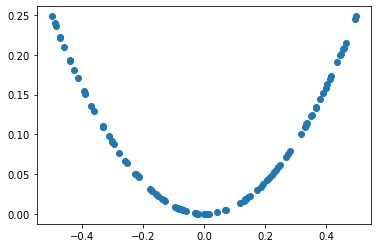

In [2]:
from numpy.random import rand
from numpy import hstack
from matplotlib import pyplot

def generate_samples(n=100):
    X1 = rand(n) - 0.5
    X2 = X1*X1
    
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    return hstack((X1, X2))

data = generate_samples()

pyplot.scatter(data[:, 0], data[:, 1])
pyplot.show()

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

def define_discriminator(n_inputs=2):
    model=Sequential()
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = define_discriminator()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                75        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


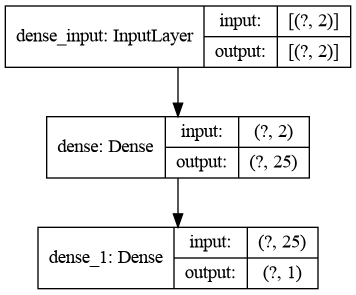

In [4]:
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [5]:
# generate n real samples with class labels
def generate_real_samples(n):
    # generate inputs in [-0.5, 0.5]
    X1 = rand(n) - 0.5
    # generate outputs X^2
    X2 = X1 * X1
    # stack arrays
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    X = hstack((X1, X2))
    # generate class labels
    y = np.ones((n, 1))
    return X, y

# generate n fake samples with class labels
def generate_fake_samples(n):
    # generate inputs in [-1, 1]
    X1 = -1 + rand(n) * 2
    # generate outputs in [-1, 1]
    X2 = -1 + rand(n) * 2
    # stack arrays
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    X = hstack((X1, X2))
    # generate class labels
    y = np.zeros((n, 1))
    return X, y

In [6]:
# train the discriminator model
def train_discriminator(model, n_batches=1000, n_samples=128):
    half_batch = int(n_samples / 2)
    # run epochs manually
    for i in range(n_batches):
        # generate real examples
        X_real, y_real = generate_real_samples(half_batch)
        # update model
        model.train_on_batch(X_real, y_real)
        # generate fake examples
        X_fake, y_fake = generate_fake_samples(half_batch)
        # update model
        model.train_on_batch(X_fake, y_fake)
        # evaluate the model
        _, acc_real = model.evaluate(X_real, y_real, verbose=0)
        _, acc_fake = model.evaluate(X_fake, y_fake, verbose=0)
        print(i, acc_real, acc_fake)

In [ ]:
train_discriminator(model)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 15)                90        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 32        
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________


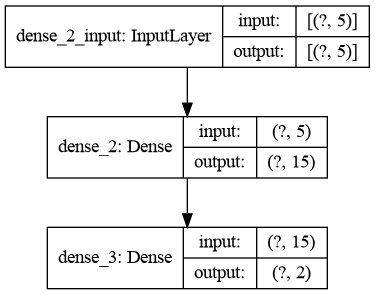

In [8]:
def define_generator(latent_dim, n_outputs=2):
    model=Sequential()
    model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(n_outputs, activation='linear'))
    return model

model = define_generator(5)
model.summary()

plot_model(model, show_shapes=True, show_layer_names=True)

In [9]:
def generate_latent_points(latent_dim, n):
    x_input = np.random.randn(latent_dim * n)
    x_input = x_input.reshape(n, latent_dim)
    return x_input

kout = generate_latent_point

In [17]:
def generate_fake_samples(generator, latent_dim, n):
    x_input = generate_latent_points(latent_dim, n)
    X = generator.predict(x_input)
    
    y = np.zeros((n, 1))
    return X, y
    
latent_dim = 5
model = define_generator(latent_dim)

In [11]:
def define_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

discriminator = define_discriminator()
generator = define_generator(latent_dim)

gan_model = define_gan(generator, discriminator)
gan_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 2)                 122       
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 101       
Total params: 223
Trainable params: 122
Non-trainable params: 101
_________________________________________________________________


In [20]:
def train_gan(gan_model, latent_dim, n_batches=10000, n_samples=128):
    for i in range(n_batches):
        x_gan = generate_latent_points(latent_dim, n_samples)
        y_gan = np.ones((n_batch, 1))
        gan_model.train_on_batch(x_gan, y_gan)

In [21]:
def train(g_model, d_model, gan_model, latent_dim, n_batches=30000, n_samples=128, n_eval=2000):
    half_batch = int(n_samples/2)
    for i in range(n_batches):
        x_real, y_real = generate_real_samples(half_batch)
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        
        x_gan = generate_latent_points(latent_dim, n_samples)
        y_gan = np.ones((n_samples, 1))
        
        gan_model.train_on_batch(x_gan, y_gan)
        
        if (i+1)%n_eval == 0:
            summarize_performance(i, g_model, d_model, latent_dim)

In [22]:
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
    x_real, y_real = generate_real_samples(n)
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    
    print(epoch+1, acc_real, acc_fake)
    
    pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
    pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
    #filename = 'generated_plot_e%03d.png' % (epoch+1)
    #pyplot.savefig(filename)
    pyplot.show()

2000 0.699999988079071 0.33000001311302185


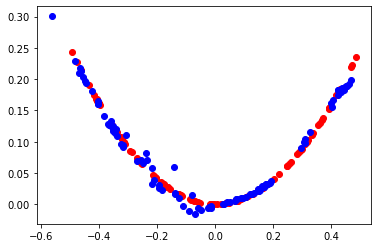

4000 0.75 0.4000000059604645


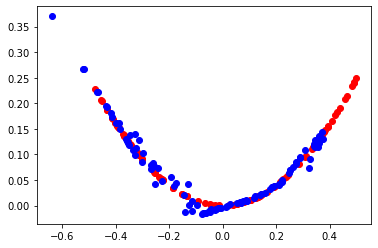

6000 0.6800000071525574 0.36000001430511475


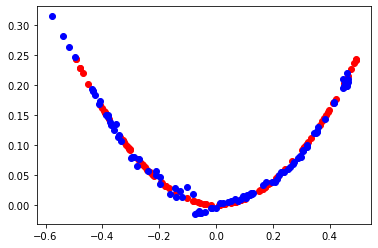

8000 0.33000001311302185 0.7300000190734863


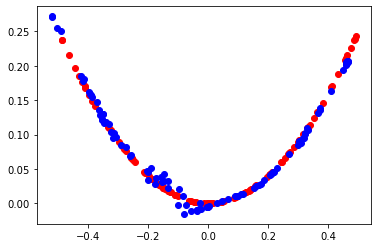

10000 0.6000000238418579 0.3799999952316284


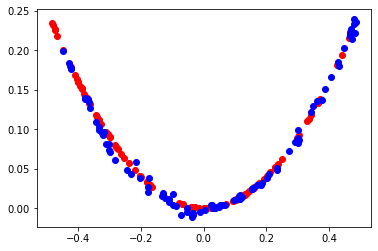

12000 0.550000011920929 0.4300000071525574


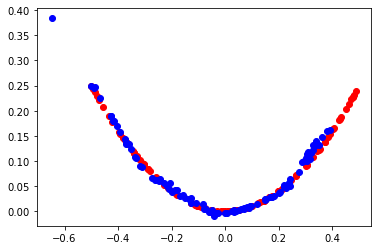

14000 0.5899999737739563 0.6700000166893005


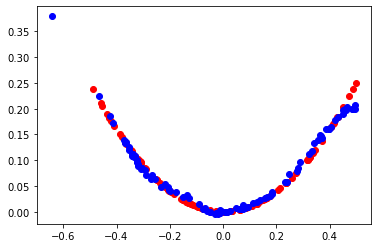

16000 0.7799999713897705 0.28999999165534973


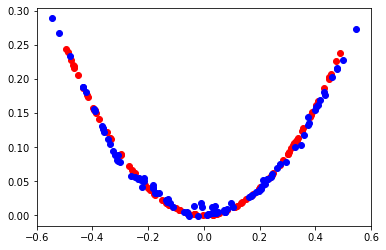

18000 0.3100000023841858 0.75


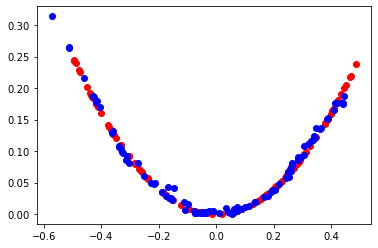

20000 0.550000011920929 0.7300000190734863


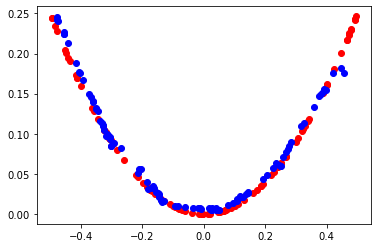

22000 0.25 0.7599999904632568


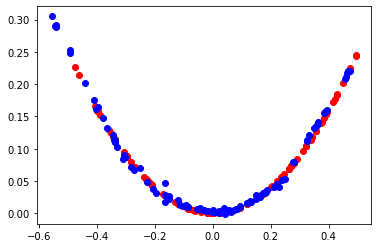

24000 0.6000000238418579 0.4300000071525574


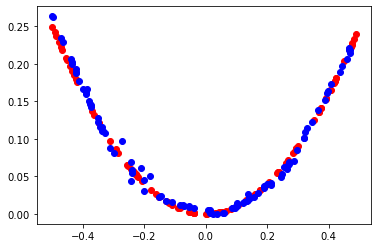

26000 0.49000000953674316 0.5199999809265137


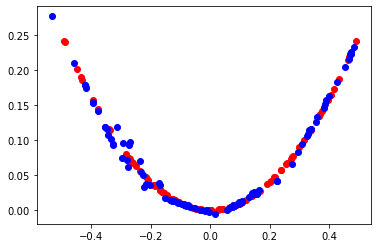

28000 0.5899999737739563 0.4099999964237213


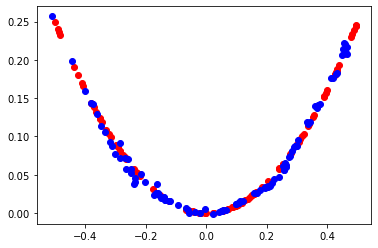

30000 0.5799999833106995 0.5400000214576721


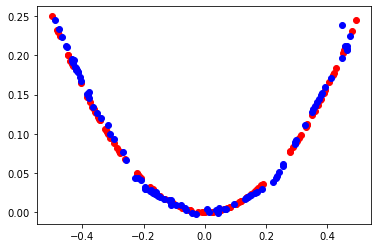

In [23]:
train(generator, discriminator, gan_model, latent_dim)